In [30]:
import os
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt

from scipy.ndimage import measurements

%matplotlib notebook

from impit.segmentation.tests.pull_data import get_lung_data
from impit.segmentation.cardiac.run import run_cardiac_segmentation

In [2]:
images = get_lung_data(number_of_patients=10)

2020-08-11 02:01:18.488 | DEBUG    | impit.segmentation.tests.pull_data:fetch_data:134 - Path exists: /impit/segmentation/tests/data/dynamic/lung/LCTSC-Train-S1-001, won't fetch data
2020-08-11 02:01:18.522 | DEBUG    | impit.segmentation.tests.pull_data:fetch_data:134 - Path exists: /impit/segmentation/tests/data/dynamic/lung/LCTSC-Train-S1-002, won't fetch data
2020-08-11 02:01:18.523 | DEBUG    | impit.segmentation.tests.pull_data:fetch_data:134 - Path exists: /impit/segmentation/tests/data/dynamic/lung/LCTSC-Train-S1-003, won't fetch data
2020-08-11 02:01:18.524 | DEBUG    | impit.segmentation.tests.pull_data:fetch_data:134 - Path exists: /impit/segmentation/tests/data/dynamic/lung/LCTSC-Train-S1-004, won't fetch data
2020-08-11 02:01:18.524 | DEBUG    | impit.segmentation.tests.pull_data:fetch_data:134 - Path exists: /impit/segmentation/tests/data/dynamic/lung/LCTSC-Train-S1-005, won't fetch data
2020-08-11 02:01:18.525 | DEBUG    | impit.segmentation.tests.pull_data:fetch_data:13

In [3]:
settings = {
    "outputFormat": "Auto_{0}.nii.gz",
    "atlasSettings": {
        "atlasIdList": ["001","002","003","004","005","006","007"],
        "atlasStructures": ["Heart","Esophagus","Lung_L","Lung_R","SpinalCord"],
        "atlasPath": "../tests/data/dynamic/lung",
        "atlasImageFormat": "LCTSC-Train-S1-{0}/CT.nii.gz",
        "atlasLabelFormat": "LCTSC-Train-S1-{0}/Struct_{1}.nii.gz",
        "autoCropAtlas":True
    },
    "autoCropSettings": {"expansion": [0,0,0],},
    "rigidSettings": {
        "initialReg": "Similarity",
        "options": {
            "shrinkFactors": [16, 8, 4, 2],
            "smoothSigmas": [0, 0, 0, 0],
            "samplingRate": 0.75,
            "defaultValue": -1024,
            "numberOfIterations": 50,
            "finalInterp": sitk.sitkBSpline,
            "metric": "mean_squares",
            "optimiser": "gradient_descent"
        },
        "trace": False,
        "guideStructure": False,
    },
    "deformableSettings": {
        "isotropicResample": True,
        "resolutionStaging": [16, 8, 2],  # specify voxel size (mm) since isotropic_resample is set
        "iterationStaging": [15, 15, 15],
        "smoothingSigmas": [4, 2, 1],
        "ncores": 8,
        "trace": False,
    },
    "IARSettings": {
        "referenceStructure": "Heart",
        "smoothDistanceMaps": True,
        "smoothSigma": 1,
        "zScoreStatistic": "MAD",
        "outlierMethod": "IQR",
        "outlierFactor": 1.5,
        "minBestAtlases": 5,
        "project_on_sphere": False,
    },
    "labelFusionSettings": {
        "voteType": "unweighted",
        "voteParams": {},  # No parameters needed for majority voting
        "optimalThreshold": {"Heart":0.5,
                             "Esophagus":0.5,
                             "Lung_L":0.5,
                             "Lung_R":0.5,},
    },
    "vesselSpliningSettings": {
        "vesselNameList": ["SpinalCord"],
        "vesselRadius_mm": {"SpinalCord": 6},
        "spliningDirection": {"SpinalCord": "z"},
        "stopCondition": {"SpinalCord": "count"},
        "stopConditionValue": {"SpinalCord": 1},
    },
}

In [47]:
test_image = sitk.ReadImage('../tests/data/dynamic/lung/LCTSC-Train-S1-008/CT.nii.gz')

In [48]:
auto_structures = run_cardiac_segmentation(test_image, settings)

lume reduced by factor 4.32
2020-08-11 02:37:42.168 | INFO     | impit.segmentation.cardiac.run:run_cardiac_segmentation:151 - Automatically cropping atlas: 002
2020-08-11 02:37:43.267 | INFO     | impit.segmentation.cardiac.run:run_cardiac_segmentation:164 -   > Volume reduced by factor 7.48
2020-08-11 02:37:44.348 | INFO     | impit.segmentation.cardiac.run:run_cardiac_segmentation:151 - Automatically cropping atlas: 003
2020-08-11 02:37:45.264 | INFO     | impit.segmentation.cardiac.run:run_cardiac_segmentation:164 -   > Volume reduced by factor 5.05
2020-08-11 02:37:46.442 | INFO     | impit.segmentation.cardiac.run:run_cardiac_segmentation:151 - Automatically cropping atlas: 004
2020-08-11 02:37:47.463 | INFO     | impit.segmentation.cardiac.run:run_cardiac_segmentation:164 -   > Volume reduced by factor 5.66
2020-08-11 02:37:48.447 | INFO     | impit.segmentation.cardiac.run:run_cardiac_segmentation:151 - Automatically cropping atlas: 005
2020-08-11 02:37:49.388 | INFO     | impi

In [7]:
# Optionally write the automatic segmentations to disk
"""
output_name = settings["outputFormat"]

for struct_name in list(auto_structures.keys()):
    sitk.WriteImage(auto_structures[struct_name], output_name.format(struct_name))
"""

In [49]:
image_arr = sitk.GetArrayFromImage(test_image)
auto_structures_arr = {struct:sitk.GetArrayFromImage(auto_structures[struct]) for struct in auto_structures.keys()}

In [50]:
z,y,x = np.array(measurements.center_of_mass(auto_structures_arr['Heart']), dtype=np.int)

(SagSize, CorSize, AxSize) = test_image.GetSize()
spPlane, _, spSlice = test_image.GetSpacing()
asp = (spSlice/spPlane)

fSize = (6, 6.0*(asp*AxSize+CorSize)/(1.0*SagSize+CorSize))

color_list = plt.cm.Spectral(np.linspace(0,1,len(auto_structures_arr.keys())))

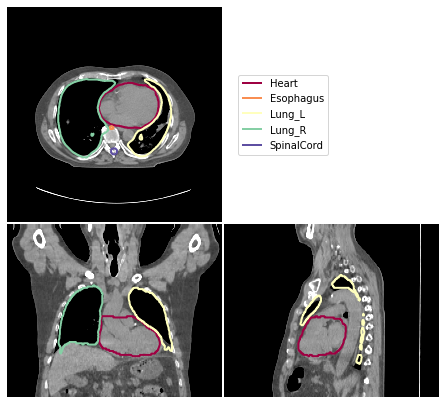

In [51]:

fig, ((axAx, blank), (axCor, axSag)) = plt.subplots(2, 2, figsize=fSize,gridspec_kw = {'height_ratios':[CorSize,asp*AxSize],'width_ratios': [SagSize,CorSize]})
blank.axis('off')

imAx = axAx.imshow(image_arr[z,:,:], cmap=plt.cm.gray)
axAx.axis('off')

imCor = axCor.imshow(image_arr[:,y,:], origin='lower', aspect=asp, cmap=plt.cm.gray)
axCor.axis('off')

imSag = axSag.imshow(image_arr[:,:,x], origin='lower', aspect=asp, cmap=plt.cm.gray)
axSag.axis('off')

for i, struct in enumerate(auto_structures.keys()):
    colour = color_list[i,:3]
    temp = axAx.contour(auto_structures_arr[struct][z,:,:], levels=[0], linewidths=2, colors=[colour])
    temp.collections[0].set_label(struct)
    axCor.contour(auto_structures_arr[struct][:,y,:], levels=[0], linewidths=2, colors=[colour])
    axSag.contour(auto_structures_arr[struct][:,:,x], levels=[0], linewidths=2, colors=[colour])

vmin = -250; window=500
imAx.set_clim(vmin,vmin+window)
imCor.set_clim(vmin,vmin+window)
imSag.set_clim(vmin,vmin+window)

axAx.legend(loc='center left', bbox_to_anchor=(1.05,0.5))

fig.subplots_adjust(left=0, right=1, wspace=0.01, hspace=0.01, top=1, bottom=0)